## First, let's import the modules we need.

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys, os, re

sys.path.append('../../')
print(os.getcwd())

from qml4omics import qml_winner
from qml4omics.visualization import visualize_correlation

##### This notebook generates spearman correlation plots that correlate the data characteristics with each model's performance
##### It also generates bar plots that count for how many input data sets did the models yield performance metrics (f1 score, auc, accuracy) above a certain threshold

## Next, let's gather the results and data evaluations you wish to analyze.

In [ ]:
home_dir = re.sub( 'qml4omics.*', 'qml4omics', os.getcwd() )

########### Select the data you want to concatenate in your dataframe to be analyzed

## for anayzing a specific set of results in a specific directory, you can just load them directly as follows:
# data_results = pd.read_csv( os.path.join( home_dir, 'results', 'basic_config', 'dataset=ALL', 'simulator_2025-05-09_15-39-33', 'ModelResults.csv') )
# data_evals = pd.read_csv( os.path.join( home_dir, 'results', 'basic_config', 'dataset=ALL', 'simulator_2025-05-09_15-39-33', 'RawDataEvaluation.csv') )
# rawevals_df = pd.concat([data_evals])
# results_df = pd.concat([data_results])

# or you can load all the results from results directory and concatenate them - this is useful if you want to analyze all the results from several different runs.
data_evals = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(home_dir, 'results')) for f in filenames if f == 'RawDataEvaluation.csv']
data_result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(home_dir, 'results')) for f in filenames if f == 'ModelResults.csv']

rawevals_df=[]
for fl in data_evals:
    rawevals_df.append(pd.read_csv(fl))
rawevals_df = pd.concat(rawevals_df)
# this will create a dataframe with all the data complexity evaluations, and save it to a csv file
rawevals_df.to_csv( os.path.join(home_dir, 'tutorial_notebooks', 'analyses', 'tutorial_results', 'compiled_raw_data_evaluations.csv'), index=False )
results_df = []
for fl in data_result:
    results_df.append( pd.read_csv(fl) )
results_df = pd.concat( results_df )
# these two lines below add a couple columns to the dataframe, consolidating certain information that will be useful for plotting later
results_df['datatype'] = [ re.sub( '-.*', '', x ) for x in results_df['Dataset'] ]
results_df[ 'model_embed_datatype'] = [ row.model + '_' + row.embeddings + '_' + row.datatype for idx, row in results_df.iterrows() ]
# this will create a dataframe with all the data model results, and save it to a csv file
results_df.to_csv( os.path.join(home_dir, 'tutorial_notebooks', 'analyses', 'tutorial_results', 'compiled_results.csv'), index=False )

# use this tag to give a quick name for all outputs, reflecting what your input data sets were
tag = 'tutorial_data'

## establish output directory 
output_dir = os.path.join( home_dir, 'tutorial_notebooks', 'analyses', 'tutorial_results', 'performance_summary_and_spearman_correlation_plots')

In [ ]:
############################ 
#####Do something like this in case you have to pick out files from a bunch of different directories and subdirectories, or combine classical and quantum grid search results.

# spiral_gs_CML = pd.read_csv('/Users/raubenb/Desktop/gitrepos/QMLBench/results/spirals_short_sub300_gs_simulator_2025-03-10_18-53-00/dataset=spirals_data-3,8,9,31.csv/ModelResults.csv')
# spiral_gs_CML.rename(columns={'BestParams_GridSearch': 'Model_Parameters'}, inplace=True) 
# raw_evals = pd.read_csv('/Users/raubenb/Desktop/gitrepos/QMLBench/results/spirals_short_sub300_gs_simulator_2025-03-10_18-53-00/dataset=spirals_data-3,8,9,31.csv/RawDataEvaluation.csv')
# # spirals_data qml
# qml_results_csvs = []
# for entry in os.scandir('/Users/raubenb/Desktop/gitrepos/QMLBench/results/qml_gridsearch_spirals_data/'):
#     if entry.is_dir():
#         for file in os.listdir(entry):
#             if file.startswith('Model'):
#                 results_csv_files = os.path.join(entry, file)
#                 qml_results_csvs.append(results_csv_files)
# qml_results_dfs = []
# qml_results_dfs = [pd.read_csv(f) for f in qml_results_csvs]

# qml_results_df_concat = pd.concat(qml_results_dfs, ignore_index=True)
# gridsearch_spirals_df = pd.concat([spiral_gs_CML, qml_results_df_concat], ignore_index=True)
# results_df = gridsearch_spirals_df
# gridsearch_spirals_df = gridsearch_spirals_df.drop(columns=['Unnamed: 0'])
# gridsearch_spirals_df.to_csv('/Users/raubenb/Desktop/gitrepos/QMLBench/notebooks/analyses/gridsearch_spirals/ModelResults.csv', index=False)
#################################

## Count the number of data sets for which each ML method led to metrics above a certain threshold
## Metric: Area Under the Curve (AUC)

In [ ]:
## looking at AUC

tmp = results_df.groupby(['model','embeddings','Dataset'])['auc'].mean().reset_index()
desired_order = ['svc', 'dt', 'lr', 'rf', 'nb', 'mlp', 'qsvc', 'qnn', 'vqc', 'pqk']
# desired_order = ['qsvc', 'svc', 'rf','mlp']
tmp['model'] = pd.Categorical(tmp['model'], categories=desired_order, ordered=True)
tmp = tmp.sort_values(by='model')
tmp = tmp.reset_index(drop=True)
ax=sns.countplot(tmp[tmp["auc"]>0.7], x='model', hue='embeddings')
ax.set_title(f'{tag} file counts with Mean AUC > 0.7')
plt.savefig( os.path.join( output_dir,  tag + '-count_auc.png') )
plt.show()
plt.close()

## Count the number of data sets for which each ML method led to metrics above a certain threshold
## Metric: F1 Score

In [ ]:
## looking at F1

tmp = results_df.groupby(['model','embeddings','Dataset'])['f1_score'].mean().reset_index()
desired_order = ['svc', 'dt', 'lr', 'rf', 'nb', 'mlp', 'qsvc', 'qnn', 'vqc', 'pqk']
# desired_order = ['qsvc', 'svc', 'rf','mlp']
tmp['model'] = pd.Categorical(tmp['model'], categories=desired_order, ordered=True)
tmp = tmp.sort_values(by='model')
tmp = tmp.reset_index(drop=True)
ax=sns.countplot(tmp[tmp["f1_score"]>0.7], x='model', hue='embeddings')
ax.set_title(f'{tag} file counts with Mean F1_Score > 0.7')
plt.savefig( os.path.join( output_dir,  tag + '-count_f1.png') )
plt.show()
plt.close()

## Count the number of data sets for which each ML method led to metrics above a certain threshold
## Metric: Accuracy

In [ ]:
## looking at Accuracy

tmp = results_df.groupby(['model','embeddings','Dataset'])['accuracy'].mean().reset_index()
desired_order = ['svc', 'dt', 'lr', 'rf', 'nb', 'mlp', 'qsvc', 'qnn', 'vqc', 'pqk']
# desired_order = ['qsvc', 'svc', 'rf','mlp']
tmp['model'] = pd.Categorical(tmp['model'], categories=desired_order, ordered=True)
tmp = tmp.sort_values(by='model')
tmp = tmp.reset_index(drop=True)
ax=sns.countplot(tmp[tmp["accuracy"]>0.7], x='model', hue='embeddings')
ax.set_title(f'{tag} file counts with Mean Accuracy > 0.7')
plt.savefig( os.path.join( output_dir,  tag + '-count_accuracy.png') )
plt.show()
plt.close()


## The big question: Did QML outperform CML, for any of the datasets?
## The function below scowers your results and tries to find that out for you.

In [ ]:
# Let's see if we can find data sets where qml won
# Regardless, this function still produces a data frame with the average best performance per model, across the data sets.
qml_winner(results_df, rawevals_df, output_dir, tag)

## In any case, let's see how the models performed on average, for your data sets.

In [ ]:
# Sample DataFrame

df = pd.read_csv(os.path.join( output_dir, tag + '_best_permodel_summary.csv') )


# Plotting the barplot with error bars
ax = df.plot.bar(x='model', y=['Mean_F1_Score', 'Median_F1_Score', 'Max_F1_Score'], yerr='StandardDev_F1_Score', capsize=4)

# Add title and labels
plt.title(f'F1 Scores across {tag}')
plt.xlabel('Model')
plt.ylabel('F1_Score')

# Adjust appearance
# ax.patches[0].set_facecolor('skyblue')
# ax.patches[1].set_facecolor('lightcoral')
# ax.patches[2].set_facecolor('lightgreen')

# Show the plot
plt.savefig(os.path.join( output_dir, tag + '_F1summary.png'), bbox_inches='tight')
plt.show()
plt.close()

## The above plot gives you a rough idea of the models' performances, but we can also plot things in a more statistically intuitive way.  The cell below plots accuracy, AUC, and F1 scores using box plots.

In [ ]:
results_df['model_datatype'] = ['_'.join( [row.model, row.datatype] )  for idx, row in results_df.iterrows()]
for m in ['f1_score','accuracy', 'auc']:
    plt.figure( figsize=(6,4) )
    sns.boxplot( data = results_df, x = 'model_datatype', y = m, hue = 'embeddings' )
    plt.ylim( 0, 1)
    plt.xticks(rotation = 90 )
    plt.savefig( os.path.join( output_dir, tag + f'_{m}_boxplot.png'), bbox_inches='tight' )
    plt.show()
    plt.close()

## If you have any dataset for which at least one QML method outperformed all CML methods, the cell below will generate bar plots comparing the performances between QML and CML in these cases.  An example of what this would look like can be seen in the image below.

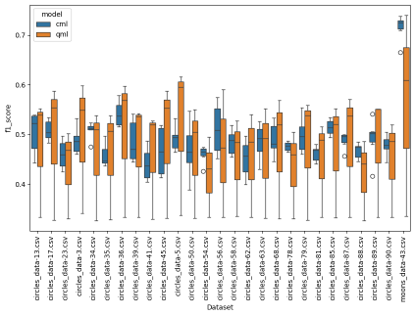

In [ ]:
# Get the datasets for which the qml did better, based on median range
# If there were no datasets in which QML outperformed CML, this cell returns a blank plot.
models_qml = ['qnn', 'vqc', 'qsvc', 'pqk']
df = results_df.copy()
df_across_split= df.groupby(['Dataset', 'embeddings', 'model', 'Model_Parameters'])['f1_score'].median().reset_index()
best_per_dataset = df_across_split.loc[df_across_split.groupby('Dataset')['f1_score'].idxmax()]
##
qml_winner = df_across_split[df_across_split['Dataset'].isin(best_per_dataset[best_per_dataset['model'].isin(models_qml)]['Dataset'])]
qml_winner['model'] = [ 'qml' if x in models_qml else 'cml' for x in qml_winner['model'] ]
plt.figure( figsize=(10,6))
sns.boxplot( data = qml_winner, x = 'Dataset', y = 'f1_score', hue = 'model' )
sns.swarmplot( data = qml_winner, x = 'Dataset', y = 'f1_score', hue = 'model' )
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()
plt.close()

## Now, given the results above, let's see how the models' performances correlate to the specific complexity measures, using Spearman correlations.  This gives you an idea of which complexity measures are most influential to the model's performance

In [ ]:
# Visualization correlation between data features and metric

_, correlation_spearman_df = visualize_correlation.compute_results_correlation(results_df=results_df, correlation='spearman', 
                                                                               thresh = 0.7)

# for m in ['f1_score', 'accuracy', 'auc' ]:
figsize = (9,7)
for m in ['f1_score']:
    visualize_correlation.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_none_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with NO embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir, tag + '_embed_NONE.png')
                                                )
    visualize_correlation.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_nmf_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with NMF embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir,tag + '_embed_NMF.png')
                                                )
    visualize_correlation.plot_results_correlation( correlation_spearman_df[correlation_spearman_df['model_embed_datatype'].str.contains('_pca_')],
                                                metric = m,
                                                title = 'Data feature correlation to ' + m + ' with PCA embedding',
                                                correlation_type = 'Color: Spearman;\nSize: ' + m,
                                                size = 'median_metric',
                                                figsize=figsize,
                                                save_file_path=os.path.join( output_dir, tag + '_embed_PCA.png')
                                                )
    # other values that can be used for size argument above include 'frac', 'median_metric', and 'frac_gt_thresh'

## Now, let's perform a clustering analyses to look at the distribution of data complexity measures in the data sets.  First, let's look at the clustering in the raw data evaluation, without any embedding.

In [ ]:
# let's reset the output directory for these plots
output_dir = os.path.join( home_dir, 'tutorial_notebooks', 'analyses', 'tutorial_results', 'performance_vs_data_complexity_plots')

features = ['Feature_Samples_ratio', 'Intrinsic_Dimension', 'Condition number',
    'Fisher Discriminant Ratio', 'Total Correlations', 'Mutual information',
    '# Non-zero entries', '# Low variance features', 'Variation', 'std_var',
    'Coefficient of Variation %', 'std_co_of_v', 'Skewness', 'std_skew',
    'Kurtosis', 'std_kurt', 'Mean Log Kernel Density',
    'Isomap Reconstruction Error', 'Fractal dimension', 'Entropy',
    ]
features.sort()
metrics = ['accuracy', 'f1_score', 'time', 'auc']
metrics.sort()

results_df = results_df.reset_index(drop=True)
results_df[results_df == math.inf] = 0
results_df = results_df.drop_duplicates()

#  You can either import rawwevals_df directly, or you can pull out the raw data evaluations from results_df by
#  keeping only the cases where no embedding was performed, and dropping the columns you don't want. 
raw_eval = results_df[( results_df.embeddings == 'none')]
raw_eval = raw_eval.drop(metrics + ['model_embed_datatype', 'embeddings', 'iteration', 'model', 'Model_Parameters'], axis = 1).drop_duplicates()
# raw_eval = raw_eval.drop(metrics + ['model_embed_datatype', 'embeddings', 'iteration'], axis = 1).drop_duplicates()
raw_eval = raw_eval.drop_duplicates()

#results_df = results_df[( results_df.embeddings != 'none') ]
results_df.shape
results_df.columns

embeddings = list(set(results_df['embeddings']))
#embeddings.remove('none')
embeddings.sort()
models = list(set(results_df['model']))
models.sort()
datatypes = list(set(results_df['datatype']))
datatypes.sort()

models_qml = ['qnn', 'vqc', 'qsvc', 'pqk' ]
models_cml = [ x for x in models if x not in models_qml ]


df_temp = raw_eval.copy()
# If your results inlcude only embeddings, you can use the following line to get the raw data evaluations instead.
#df_temp = rawevals_df.copy()
df_temp = df_temp[ ['Dataset'] + features ]
df_temp = df_temp.drop_duplicates()
df_temp = df_temp.melt( id_vars='Dataset', value_vars=features)
df_temp = df_temp.pivot_table( index='Dataset', columns='variable', values='value')
df_temp['Coefficient of Variation %'] = [float(x) for x in df_temp['Coefficient of Variation %'] ]
df_temp['std_co_of_v'] = [float(x) for x in df_temp['std_co_of_v'] ]

df_temp[ df_temp == math.inf ] = 0

datasets = list( set([ re.sub( '-.*', '', re.sub( '.csv', '', x ) ) for x in  df_temp.index ] ) )

custom_palette = sns.color_palette(n_colors=len(datasets))
datasets_cmap = dict( zip( datasets, custom_palette ) )
rcolors = [ datasets_cmap[ re.sub( '-.*', '', re.sub( '.csv', '', x ) )] for x in  df_temp.index ]

df_temp = df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors, xticklabels=False )

# g = sns.clustermap( data= results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors, xticklabels=False )

# Add a legend for row colors
for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

## If you have any dataset for which at least one QML method outperformed all CML methods, the cell below will generate these modified clustering heat maps, allowing you to see how the complexity measures differ among these datasets, relative to the rest of the datasets.  The example below is once again, for the case where there are no embeddings; in other words this is still the clustering observed in the complexity evaluations of the raw data.

In [ ]:
# reload the data frames
df_temp = raw_eval.copy()
df_temp = df_temp[ ['Dataset'] + features ]
df_temp = df_temp.drop_duplicates()
df_temp = df_temp.melt( id_vars='Dataset', value_vars=features)
df_temp = df_temp.pivot_table( index='Dataset', columns='variable', values='value')

df_temp[ df_temp == math.inf ] = 0

rcolors_df = []
rcolors_df.append( [ datasets_cmap[ re.sub( '-.*', '', re.sub( '.csv', '', x ) )] for x in  df_temp.index ] )
rcolors_df.append( [ 'magenta' if x in list(qml_winner['Dataset']) else 'tan' for x in  df_temp.index ] )

df_temp = df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# g = sns.clustermap( data=results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# Add a legend for row colors
datasets_cmap.update( { 'qml_winner' : 'magenta', 'cml_winner' : 'tan'})
for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

## It is also worth comparing the clustering of complexity measures, on the embedded data sets.  The heat map below will now show how the complexity changes before and after embedding the data.

In [ ]:
results_df_temp = results_df.copy()
results_df_temp['key'] = [ '_'.join( [row.embeddings, row.Dataset] ) for idx, row in results_df_temp.iterrows() ]
results_df_temp = results_df_temp[ ['key'] + features ]
results_df_temp = results_df_temp.drop_duplicates()
results_df_temp = results_df_temp.melt( id_vars='key', value_vars=features)
results_df_temp = results_df_temp.pivot_table( index='key', columns='variable', values='value')

results_df_temp[ results_df_temp == math.inf ] = 0
qml_winner['embed_dataset'] = [ '_'.join( [row.embeddings, row.Dataset]) for idx, row in qml_winner.iterrows() ]

embeds = list( set([ re.sub( '_.*', '', re.sub( '.csv', '', x ) ) for x in  results_df_temp.index ] ) )

custom_palette = sns.color_palette('dark', n_colors=len(embeds))
embeds_cmap = dict( zip( embeds, custom_palette ) )

rcolors_df = []
rcolors_df.append( [ datasets_cmap[ '_'.join(re.sub( '-.*', '', re.sub( '.csv', '', x )).split('_')[1:])] for x in  results_df_temp.index ] )
rcolors_df.append( [ embeds_cmap[ re.sub( '_.*', '', x ) ] for x in  results_df_temp.index ] )
rcolors_df.append( [ 'magenta' if x in list(qml_winner['embed_dataset']) else 'tan' for x in  results_df_temp.index ] )

df_temp = results_df_temp.fillna(0).transpose().apply( lambda x : (x - min(x))/(max(x)-min(x)), axis = 1).fillna(0)
g = sns.clustermap( data= df_temp, figsize=(10,8), cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# g = sns.clustermap( data=results_df_temp.fillna(0).transpose(), figsize=(17,8), standard_scale=0, cmap = 'vlag', center = 0, col_colors=rcolors_df, xticklabels=False )

# Add a legend for row colors
datasets_cmap.update(embeds_cmap)
datasets_cmap.update( { 'qml_winner' : 'magenta', 'cml_winner' : 'tan'})

for label, color in datasets_cmap.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=label)
g.ax_row_dendrogram.legend(loc="lower right")

plt.show()
plt.close()

##  Finally, let's plot performance metrics against each range of data complexity measures.

In [ ]:
for m in ['f1_score']:
# for m in ['f1_score', 'auc', 'accuracy' ]:
    for f in features:
        for e in embeddings:
            to_plot = results_df[ (~results_df[metrics[0]].isna()) & ( results_df['embeddings'] == e ) ]
            to_plot['model'] = [ 'qml' if x in models_qml else 'cml' for x in to_plot['model']]
            sns.lineplot(
                        data = to_plot,
                        x = f,
                        y = m,
                        hue = 'model',
                    )
            plt.title( e )
            plt.ylim(0,1)
            plt.savefig( os.path.join( output_dir, '_'.join( ['Performance_embed', e, re.sub( '\ ', '-', f), m, '.png'])))
            #plt.show()
            plt.close()

## An example of these outputs can be seen below, where the F1 score varies differently between CML and QML methods, with respect to kurtosis, mutual information, and fractal dimension, when the data is embedded with PCA. 
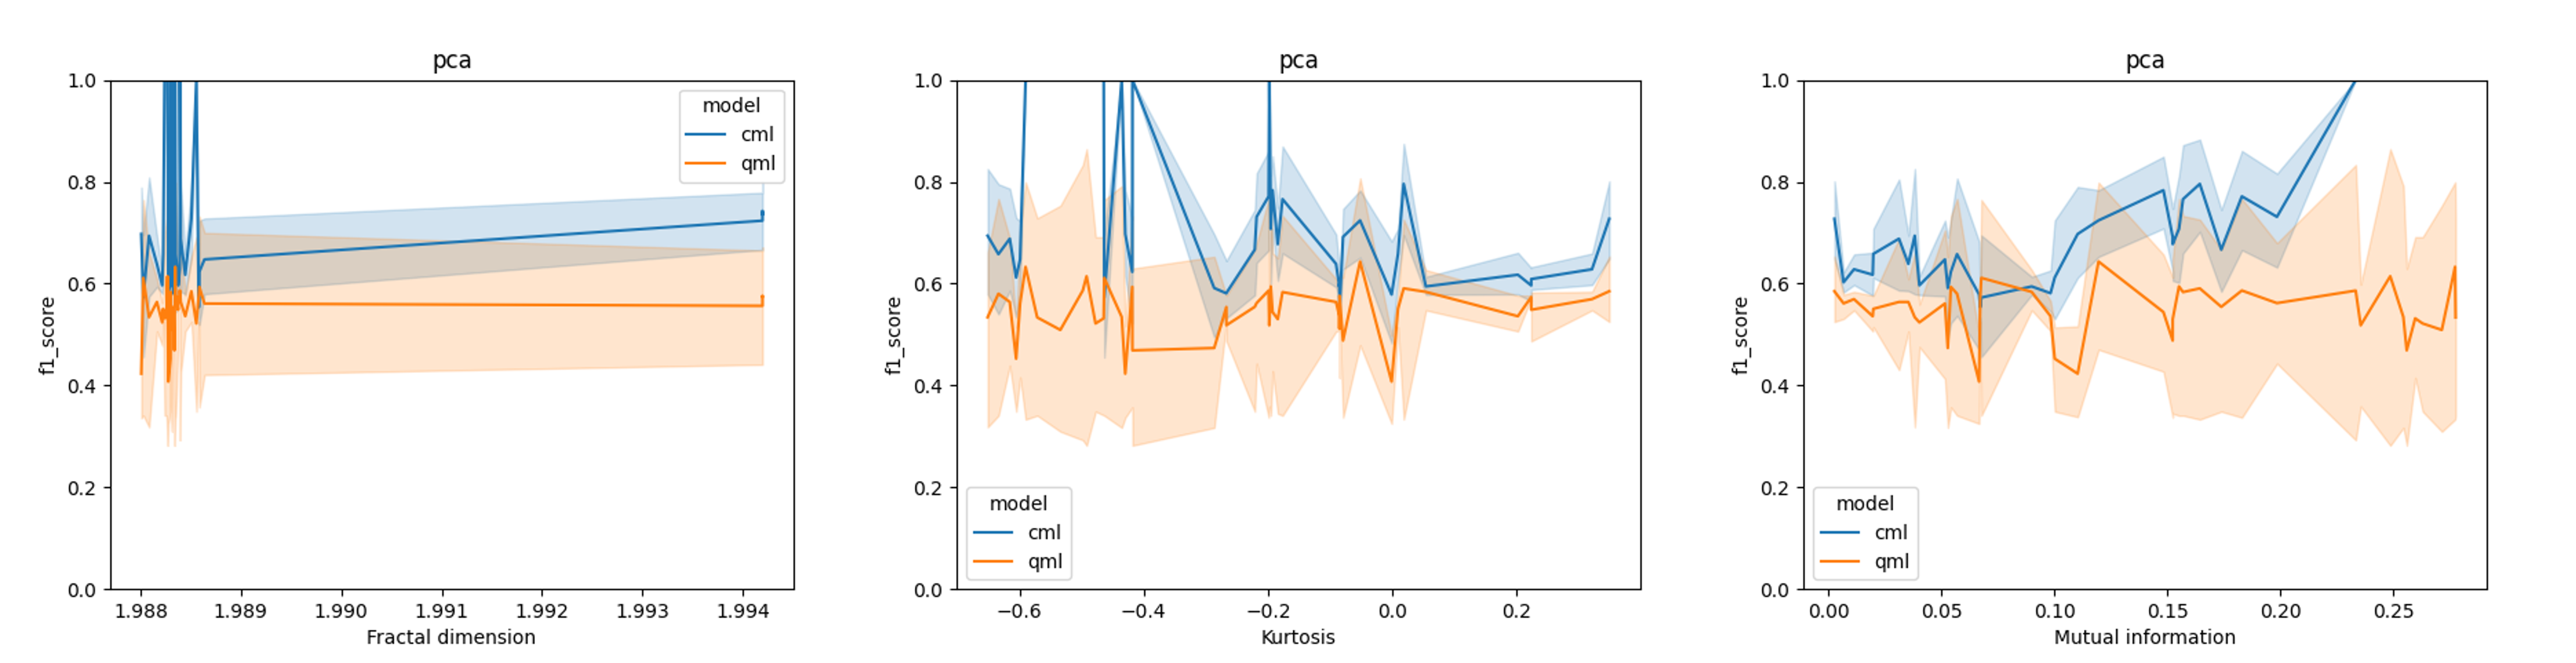